# Estimating Eigenspectrum of Hessians

Setup libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import math
from IPython.display import Markdown, display
%matplotlib inline
def printmd(string):
    display(Markdown(string))

## Generate Random Hessian

In [2]:
n = 200
X = np.random.randn(150,n)
H = np.matmul(X.transpose(),X)

## Compute Eigenvalue Spectrum

In [3]:
L = np.linalg.eigvalsh(H)
Lnz = [l for l in L if l>1.0e-12]
print("Number of non-zero eigenvalues = ", len(Lnz))

Number of non-zero eigenvalues =  150


Fit polynomial to spectrum

In [4]:
x = np.linspace(1,len(Lnz), len(Lnz))
w = np.polyfit(x,Lnz,3)
y = np.polyval(w,x)
printmd(f'$\lambda_k$ = {w[3]:.3g} + {w[2]:.3g}$\,k$ + {w[1]:.4g}$\,k^2$ + {w[0]:.3g}$\,k^3$')

$\lambda_k$ = -9.25 + 2.06$\,k$ + -0.01622$\,k^2$ + 0.00021$\,k^3$

Plot eigenvalue spectrum with fit

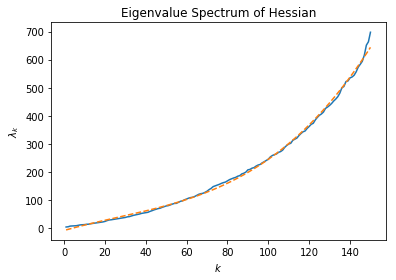

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_title("Eigenvalue Spectrum of Hessian")
ax1.set_ylabel("$\lambda_k$")
ax1.set_xlabel("$k$")
ax1.plot(x,Lnz)
ax1.plot(x,y,"--")

### Compute sums

In [6]:
L2 = sum(L**2)
L4 = 2*sum(L**4)
L6 = 8*sum(L**6)
print(f'L2 = {L2:.4g}, L4 = {L4:.4g}, L6 = {L6:.4}')

L2 = 1.094e+07, L4 = 4.906e+12, L6 = 5.922e+18


## Collect gradient information

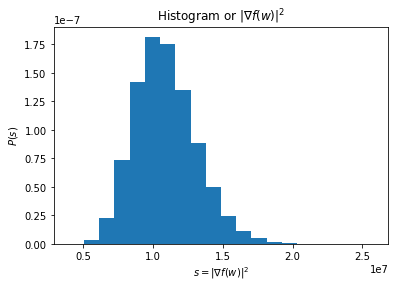

In [7]:
noS = 100000                     # number of samples
X = np.random.randn(n,noS)  # generate noS random vectors
Grad = np.matmul(H,X)
S = np.sum(Grad**2,axis=0)


# Plot histogram of gradient squared

fig2, ax2 = plt.subplots()
ax2.set_title("Histogram or $\\|\\nabla f(w)\\|^2$")
ax2.set_xlabel("$s=\\|\\nabla f(w)\\|^2$")
ax2.set_ylabel("$P(s)$")
ax2.hist(S,20, normed=1);

Compute cumulants of squared gradients

In [20]:
kappa=[None]*4
kappa[1] = np.mean(S)
kappa[2] = np.var(S)
kappa[3] = noS*sum((S-kappa[1])**3)/((noS-1)*(noS-2))


# Estimate kVaror
N = 10;
Ssplit = np.split(S,N)
k1list = []
k2list = []
k3list = []
for Ssmall in np.split(S,N):
    k1s=np.mean(Ssmall)
    k1list.append(k1s)
    k2list.append(np.var(Ssmall))
    noSs=len(Ssmall)
    k3s=noSs*sum((Ssmall-k1s)**3)/((noSs-1)*(noSs-2))
    k3list.append(k3s)
kVar = [None]*4
kVar[1] = np.var(k1list)/N
kVar[2] = np.var(k2list)/N
kVar[3] = np.var(k3list)/N

def myformat(d,i):
    f="{:."+str(i)+"g}"
    return f.format(round(d,i))
s=""
for i in range(1,4):
    s += '$\kappa_{' + str(i) + '}\,=\,$' + myformat(kappa[i],4) + '$\,\pm\,$' + myformat(math.sqrt(kVar[i]),2)
    if i<3:
        s += ", "
printmd(s)

$\kappa_{1}\,=\,$1.093e+07$\,\pm\,$5.8e+03, $\kappa_{2}\,=\,$4.895e+12$\,\pm\,$2.3e+10, $\kappa_{3}\,=\,$5.823e+18$\,\pm\,$6.2e+16

## Monte Carlo

In [16]:
nstar = round(n/2)
p = np.array([1/(n*n),0,2,0])
a = 400   # step size


def kFromSpectra(nstar, p):        # compute cumulants from eigenvalue spectrum
    k=np.linspace(1,nstar,nstar)
    l=np.polyval(p,k)
    return [0, sum(l**2), 2*sum(l**4), 8*sum(l**8)]

def logprob(k, kappa, err):        # gaussian error
    lp = 1.0
    for i in range(1,4):
        lp += -0.5*(k[i]-kappa[i])**2/err[i] # - 0.5*math.log(2*math.pi*err[i])
    return lp

def newGamma(m):                   # new update parameter
    return m*random.gamma(a,1/a)


def loga(m,m1):
    r = m/m1
    return -a*(math.log(r) - r + 1/r)  # includes Jeffreys prior

kold = kFromSpectra(nstar,p)
lpold = logprob(kold, kappa, kVar)
accept = 0
Iterations = 10000
for iter in range(Iterations):
    nstar1 = nstar + random.randint(-2,3)
    p1 = np.array([0.0,0.0,0.0,0.0])
    la = 0;
    for i in range(3):
        if p[i]==0:
            continue
        m1 = newGamma(p[i])
        la += loga(p[i], m1)
        p1[i] = m1
    ke = kFromSpectra(nstar1,p1)
    lp = logprob(ke, kappa, kVar)
    sumLogProb = la +lp -lpold
    if (sumLogProb>0 or random.rand()<math.exp(sumLogProb)):
        p = p1.copy()
        lpold = lp
        nstar = nstar1
        accept = accept +1

print("Acceptance rate = ", accept/Iterations)

def printKappa(k):
    s = ""
    for i in range(1,4):
        s += '$\kappa_{' + str(i) + '}\,=\,$' + myformat(k[i],4)
        if i<3:
            s += ", "
    printmd(s)

print(nstar,p)
printKappa(kFromSpectra(nstar,p))
printKappa(kappa)
print(kVar)

Acceptance rate =  0.0956
1159 [1.94526868e-10 0.00000000e+00 9.94929779e-02 0.00000000e+00]


$\kappa_{1}\,=\,$5.16e+06, $\kappa_{2}\,=\,$8.276e+10, $\kappa_{3}\,=\,$3.289e+19

$\kappa_{1}\,=\,$1.093e+07, $\kappa_{2}\,=\,$4.895e+12, $\kappa_{3}\,=\,$5.823e+18

[None, 33550750.86398398, 5.3174030439113805e+20, 3.8686334598169644e+33]
